In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
from keras import optimizers
import tensorflow as tf 
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import joblib
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/Ingrid"

/content/drive/.shortcut-targets-by-id/1hFPS4tqGTnlvy4uMbNCw1sS-rQHO25oe/Ingrid


In [ ]:
df= pd.read_csv('data_05_shaft_bearing.csv')

In [ ]:
df= df.dropna()
df=df[df['power']>100]
df= df[df['outdoor_temp']>0]
df= df[df['nacelle']>0]
df= df[df['generator_speed']>0]
df= df[df['gearbox_bearing']>0]
df.drop(columns=["Unnamed: 0"],inplace=True)
print(df)

features = ['generator_speed', 'nacelle']
target = ['gearbox_bearing']
X = df[features]
y = df[target]

PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)

                      sample_time      power  outdoor_temp  generator_speed  \
0       2018-01-01 00:00:00+00:00  668.28204     32.369460        973.59010   
1       2018-01-01 00:10:00+00:00  396.09955     32.322247        851.24150   
2       2018-01-01 00:20:00+00:00  337.86740     32.230736        835.06190   
3       2018-01-01 00:30:00+00:00  326.90180     32.051624        830.00200   
4       2018-01-01 00:40:00+00:00  400.90637     31.891493        843.18300   
...                           ...        ...           ...              ...   
157809  2020-12-31 21:30:00+00:00  463.78204     30.680513        886.92694   
157810  2020-12-31 21:40:00+00:00  472.37115     30.551275        884.98804   
157811  2020-12-31 21:50:00+00:00  579.70490     30.431310        939.09460   
157812  2020-12-31 22:00:00+00:00  554.78850     30.328987        927.96220   
157813  2020-12-31 22:10:00+00:00  194.68222     30.234390        352.50555   

          nacelle  gearbox_bearing  
0       39.058

In [ ]:
X_train= X[0:100000]
y_train= y[0:100000]
X_validation = X[10000:105120]
y_validation = y[10000:105120]
X_test= X[105120:]
y_test= y[105120:]

In [ ]:
  model = Sequential()
  model.add(LSTM(100,activation='selu', input_shape = (X.shape[1],1),return_sequences=True))
  model.add(LSTM(200,activation='selu', return_sequences=False))
  model.add(Dense(1, activation='selu'))
  model.compile(optimizer='adam', loss="mse", metrics=['mae'])

In [ ]:
# Fitting the ANN to the Training set
history= model.fit(X_train, y_train ,batch_size = 60, epochs = 10, validation_data=(X_validation, y_validation))

Epoch 1/10
1667/1667 [==============================] - 40s 21ms/step - loss: 0.3405 - mae: 0.4670 - val_loss: 0.3204 - val_mae: 0.4515
Epoch 2/10
1667/1667 [==============================] - 32s 19ms/step - loss: 0.3311 - mae: 0.4611 - val_loss: 0.3233 - val_mae: 0.4588
Epoch 3/10
1667/1667 [==============================] - 32s 19ms/step - loss: 0.3305 - mae: 0.4610 - val_loss: 0.3197 - val_mae: 0.4525
Epoch 4/10
1667/1667 [==============================] - 33s 20ms/step - loss: 0.3293 - mae: 0.4603 - val_loss: 0.3201 - val_mae: 0.4562
Epoch 5/10
1667/1667 [==============================] - 31s 19ms/step - loss: 0.3294 - mae: 0.4601 - val_loss: 0.3201 - val_mae: 0.4549
Epoch 6/10
1667/1667 [==============================] - 32s 19ms/step - loss: 0.3285 - mae: 0.4596 - val_loss: 0.3203 - val_mae: 0.4585
Epoch 7/10
1667/1667 [==============================] - 41s 25ms/step - loss: 0.3286 - mae: 0.4598 - val_loss: 0.3198 - val_mae: 0.4572
Epoch 8/10
1667/1667 [==========================

In [ ]:
Predictions=model.predict(X_test)
Predictions=TargetVarScalerFit.inverse_transform(Predictions)
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)
Test_Data=PredictorScalerFit.inverse_transform(X_test)

In [ ]:
df_teste=pd.DataFrame(data=Test_Data, columns=features)
df_teste['original']=y_test_orig
df_teste['predicted']=Predictions
df_teste.head()

,generator_speed,nacelle,original,predicted
0,1242.5048,29.280334,62.573334,64.560646
1,1440.3514,31.264334,65.407670,65.558624
2,1336.6907,29.424667,66.546330,64.900368
3,1430.4870,28.319500,63.864666,64.823494
4,1452.3634,28.371166,63.637500,64.854469


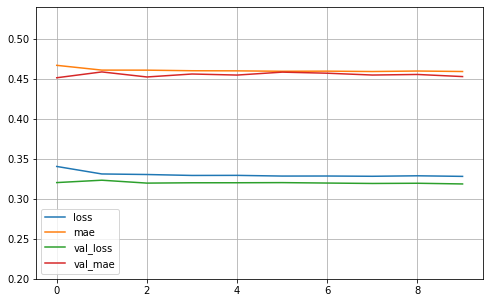

In [ ]:
%matplotlib inline

import pandas as pd

import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.2, 0.54) # set the vertical range to [0-1]
plt.show()

In [ ]:
# Computing the absolute percent error
APE=100*(abs(df_teste['original']-df_teste['predicted'])/df_teste['original'])
df_teste['APE']=APE
 
print('The Accuracy of ANN model is:', 100-np.mean(APE))
df_teste.head()

The Accuracy of ANN model is: 97.8992171111358


,generator_speed,nacelle,original,predicted,APE
0,1242.5048,29.280334,62.573334,64.598801,3.236949
1,1440.3514,31.264334,65.407670,65.634155,0.346267
2,1336.6907,29.424667,66.546330,64.914536,2.452118
3,1430.4870,28.319500,63.864666,64.796867,1.459651
4,1452.3634,28.371166,63.637500,64.825096,1.866189


In [ ]:
df_new= df.merge(df_teste, how='left',on=['generator_speed','nacelle'])
df_new= df_new.dropna()
df_new

,sample_time,power,outdoor_temp,generator_speed,nacelle,gearbox_bearing,original,predicted,APE
105120,2020-06-13 12:20:00+00:00,1471.88950,21.637331,1242.50480,29.280334,62.573334,62.573334,64.598801,3.236949
105121,2020-06-13 12:30:00+00:00,2269.15700,21.958326,1440.35140,31.264334,65.407670,65.407670,65.634155,0.346267
105122,2020-06-13 12:40:00+00:00,1848.58220,22.357782,1336.69070,29.424667,66.546330,66.546330,64.914536,2.452118
105123,2020-06-13 12:50:00+00:00,2222.08180,22.545212,1430.48700,28.319500,63.864666,63.864666,64.796867,1.459651
105124,2020-06-13 13:00:00+00:00,2330.56880,22.536217,1452.36340,28.371166,63.637500,63.637500,64.825096,1.866189
...,...,...,...,...,...,...,...,...,...
129808,2020-12-31 21:20:00+00:00,547.44770,30.756876,922.46820,39.576168,66.319000,66.319000,64.005333,3.488694
129809,2020-12-31 21:30:00+00:00,463.78204,30.680513,886.92694,39.403336,65.438670,65.438670,63.062874,3.630569
129810,2020-12-31 21:40:00+00:00,472.37115,30.551275,884.98804,39.182835,64.908165,64.908165,62.967182,2.990352
129811,2020-12-31 21:50:00+00:00,579.70490,30.431310,939.09460,39.011333,64.766170,64.766170,64.183746,0.899271


In [ ]:
df_teste['error']=df_teste['predicted'] - df_teste['original']
print(df_teste)

       generator_speed    nacelle   original  predicted       APE     error
0           1242.50480  29.280334  62.573334  64.598801  3.236949  2.025467
1           1440.35140  31.264334  65.407670  65.634155  0.346267  0.226485
2           1336.69070  29.424667  66.546330  64.914536  2.452118 -1.631794
3           1430.48700  28.319500  63.864666  64.796867  1.459651  0.932201
4           1452.36340  28.371166  63.637500  64.825096  1.866189  1.187596
...                ...        ...        ...        ...       ...       ...
24689        886.92694  39.403336  65.438670  63.062874  3.630569 -2.375796
24690        884.98804  39.182835  64.908165  62.967182  2.990352 -1.940983
24691        939.09460  39.011333  64.766170  64.183746  0.899271 -0.582424
24692        927.96220  38.867000  64.691170  63.953171  1.140804 -0.737999
24693        352.50555  40.111168  63.903500  59.203701  7.354525 -4.699799

[24694 rows x 6 columns]


Mean Error: 0.21508133373463856
MAE: 1.3322248829051775
RMSE: 1.7527884671005838


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


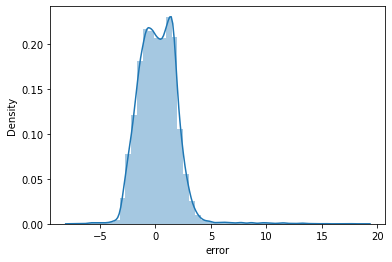

In [ ]:
%matplotlib inline
import seaborn as sns
print('Mean Error:', np.mean(df_teste['error']))
print('MAE:', np.mean(np.abs(df_teste['error'])))
print('RMSE:', np.sqrt(np.mean(df_teste['error']**2)))

sns.distplot(df_teste['error'])

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

print(mean_absolute_error(df_teste['original'], df_teste['predicted']))
print(mean_squared_error(df_teste['original'], df_teste['predicted']))
print(r2_score(df_teste['original'], df_teste['predicted']))


1.3322248829051775
3.0722674104008143
0.45490348332569164


In [ ]:
import scipy.stats as stats
df_teste['error']= -df_teste['predicted'] + df_teste['original'] 
#df_teste['error']=np.sqrt(df_teste['error'])
mean, dev = stats.norm.fit(df_teste['error'])

df_teste['error_gaussiano']=stats.norm.pdf(df_teste['error'], mean, dev)

In [ ]:
mean, dev = stats.norm.fit(df_teste['error_gaussiano'])
upper=stats.norm.ppf(0.9, loc=mean, scale=dev)
lower =stats.norm.ppf(0.1, loc=mean, scale=dev)
print(lower)
print(upper)

0.09710113803469562
0.2399603022736302


In [ ]:
error3= df_teste[df_teste['error']>=upper]
error3

,generator_speed,nacelle,original,predicted,APE,error,error_gaussiano
2,1336.69070,29.424667,66.546330,64.914536,2.452118,1.631794,0.130528
8,1427.85520,31.774834,67.612170,65.751991,2.751248,1.860179,0.112571
9,1453.60440,29.796167,66.161500,65.200531,1.452460,0.960969,0.182484
13,1398.18270,31.552168,66.933500,65.620567,1.961548,1.312933,0.155929
21,1429.23880,34.596170,67.008835,66.391243,0.921658,0.617592,0.204513
...,...,...,...,...,...,...,...
24689,886.92694,39.403336,65.438670,63.062874,3.630569,2.375796,0.075644
24690,884.98804,39.182835,64.908165,62.967182,2.990352,1.940983,0.106387
24691,939.09460,39.011333,64.766170,64.183746,0.899271,0.582424,0.206459
24692,927.96220,38.867000,64.691170,63.953171,1.140804,0.737999,0.197374


In [ ]:
error2= df_teste[df_teste['error']<=lower]
error2

,generator_speed,nacelle,original,predicted,APE,error,error_gaussiano
0,1242.50480,29.280334,62.573334,64.598801,3.236949,-2.025467,0.133438
1,1440.35140,31.264334,65.407670,65.634155,0.346267,-0.226485,0.229333
3,1430.48700,28.319500,63.864666,64.796867,1.459651,-0.932201,0.210655
4,1452.36340,28.371166,63.637500,64.825096,1.866189,-1.187596,0.196158
5,1430.18080,28.596834,63.338170,64.853355,2.392215,-1.515185,0.173453
...,...,...,...,...,...,...,...
24679,1316.40360,36.734833,63.416668,66.509911,4.877649,-3.093243,0.058348
24680,1301.28480,36.620167,63.193000,66.430595,5.123345,-3.237595,0.050688
24681,920.30520,41.825170,57.664670,64.243843,11.409366,-6.579173,0.000284
24682,1006.97064,41.378500,62.231667,65.360741,5.028105,-3.129074,0.056381


In [ ]:
error3= error3.reset_index(drop=True)
error2 = error2.reset_index(drop=True)
df_error= pd.concat([error3, error2], ignore_index=True)
df_error

,generator_speed,nacelle,original,predicted,APE,error,error_gaussiano
0,1336.69070,29.424667,66.546330,64.914536,2.452118,1.631794,0.130528
1,1427.85520,31.774834,67.612170,65.751991,2.751248,1.860179,0.112571
2,1453.60440,29.796167,66.161500,65.200531,1.452460,0.960969,0.182484
3,1398.18270,31.552168,66.933500,65.620567,1.961548,1.312933,0.155929
4,1429.23880,34.596170,67.008835,66.391243,0.921658,0.617592,0.204513
...,...,...,...,...,...,...,...
23923,1316.40360,36.734833,63.416668,66.509911,4.877649,-3.093243,0.058348
23924,1301.28480,36.620167,63.193000,66.430595,5.123345,-3.237595,0.050688
23925,920.30520,41.825170,57.664670,64.243843,11.409366,-6.579173,0.000284
23926,1006.97064,41.378500,62.231667,65.360741,5.028105,-3.129074,0.056381


In [ ]:
df_new= df_error.merge(df, how='left',on=['generator_speed', 'nacelle'])
df_new= df_new.dropna()
df_new


,generator_speed,nacelle,original,predicted,APE,error,error_gaussiano,sample_time,power,outdoor_temp,gearbox_bearing
0,1336.69070,29.424667,66.546330,64.914536,2.452118,1.631794,0.130528,2020-06-13 12:40:00+00:00,1848.5822,22.357782,66.546330
1,1427.85520,31.774834,67.612170,65.751991,2.751248,1.860179,0.112571,2020-06-13 13:40:00+00:00,2192.5635,23.955042,67.612170
2,1453.60440,29.796167,66.161500,65.200531,1.452460,0.960969,0.182484,2020-06-13 13:50:00+00:00,2329.8643,23.995396,66.161500
3,1398.18270,31.552168,66.933500,65.620567,1.961548,1.312933,0.155929,2020-06-13 14:30:00+00:00,2092.5186,24.981665,66.933500
4,1429.23880,34.596170,67.008835,66.391243,0.921658,0.617592,0.204513,2020-06-13 15:50:00+00:00,2182.0388,26.337427,67.008835
...,...,...,...,...,...,...,...,...,...,...,...
23923,1316.40360,36.734833,63.416668,66.509911,4.877649,-3.093243,0.058348,2020-12-31 18:50:00+00:00,1120.6458,31.489042,63.416668
23924,1301.28480,36.620167,63.193000,66.430595,5.123345,-3.237595,0.050688,2020-12-31 19:00:00+00:00,1080.0697,31.216616,63.193000
23925,920.30520,41.825170,57.664670,64.243843,11.409366,-6.579173,0.000284,2020-12-31 20:10:00+00:00,586.4313,32.376850,57.664670
23926,1006.97064,41.378500,62.231667,65.360741,5.028105,-3.129074,0.056381,2020-12-31 20:20:00+00:00,724.7056,32.093470,62.231667


In [ ]:
df_new['sample_time'] = pd.to_datetime(df_new['sample_time'])
df_new['sample_time']= df_new.sample_time.dt.strftime("%Y-%m-%d")

In [ ]:
df_new['sample_time'] = pd.to_datetime(df_new['sample_time'])
df_new['sample_time']= df_new.sample_time.dt.strftime("%Y-%m-%d")
df_new = df_new.groupby(['sample_time']).count()

In [ ]:
df_alarm= df_new[df_new['error_gaussiano']>101]
df_alarm.index.size
df_alarm

,generator_speed,nacelle,original,predicted,APE,error,error_gaussiano,power,outdoor_temp,gearbox_bearing
sample_time,,,,,,,,,,
2020-06-14,122,122,122,122,122,122,122,122,122,122
2020-06-15,139,139,139,139,139,139,139,139,139,139
2020-06-16,142,142,142,142,142,142,142,142,142,142
2020-06-17,140,140,140,140,140,140,140,140,140,140
2020-06-18,137,137,137,137,137,137,137,137,137,137
...,...,...,...,...,...,...,...,...,...,...
2020-12-01,129,129,129,129,129,129,129,129,129,129
2020-12-02,103,103,103,103,103,103,103,103,103,103
2020-12-20,104,104,104,104,104,104,104,104,104,104
